# Laplacian Associative Memory (LAM) - KARATE

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx, scipy.linalg
from tqdm import tqdm

In [2]:
class LAM():
    def __init__(self, N, P, prob, H, gamma, norm_mode):
        self.N = N
        self.P = P
        self.prob = prob
        self.H = H
        self.gamma = gamma
        self.norm_mode = norm_mode

        self.V = self.prob * (1-self.prob)
        self.NV = self.N * self.V
        
        # GENERATE PATTERNS
        self.xi = (np.random.rand(self.N, self.P) < self.prob).astype('float') # Binary dipole (+/-) input with sparsity
        self.xi_mean = np.sum(self.xi, axis=1, keepdims=True) / self.P
        self.xi_bias = self.xi - self.xi_mean

        # NORMALIZATION
        if self.norm_mode == "sym": # SYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-0.5)
            self.H = Dnorm @ self.H @ Dnorm
            self.Wauto = (self.xi_bias @ self.xi_bias.T) / self.NV
            self.Whetero = (self.xi_bias @ self.H @ self.xi_bias.T) / self.NV
            self.WG = self.gamma / self.N

        elif self.norm_mode == "asym": # ASYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-1) # Degree matrix
            self.H = Dnorm @ self.H # Hetero-associative weights
            self.Wauto = (self.xi @ self.xi.T) / self.NV # Local inhibition
            self.Whetero = (self.xi @ self.H @ self.xi.T) / self.NV # Excitatory
            self.WG = self.P * self.xi_mean @ self.xi_mean.T / self.NV + self.gamma / self.N # Global inhibition
        else:
            print("Error: Normalization mode 'sym' or 'asym' was not specified.")
            exit()

    def _step(self, z): # Heaviside step function
        return 0.5 * np.sign(z) + 0.5

    def _set_weight(self, a): # Decompose weights
        self.W = a * self.Wauto + self.Whetero - (a+1) * self.WG

    def simulate_single(self, a, eta, epochs, start_node, energycheck=True):
        self._set_weight(a)
        self.x = self.xi[:, start_node] + 0.0
        self.m_log = np.zeros([epochs, self.P])
        self.obj_log = np.zeros([epochs])

        for t in range(epochs):
            self.r = self._step(self.W @ self.x) # Threshold activation
            self.x += eta * (self.r - self.x) 
            self.m = (self.xi_bias.T @ self.x) / self.NV # Pattern overlap
            self.m_log[t,:] = self.m

            if energycheck:
                self.obj_log[t] = -(self.x).T @ self.W @ self.x / self.NV # Compute energy

        return (self.m_log, self.obj_log)
    
    def simulate_allstarts(self, a, eta, simlen):
        self._set_weight(a)
        self.x = self.xi + 0.0
        self.m_log = np.zeros([simlen,self.P,self.P])

        for t in range(simlen):
            self.r = self._step(self.W @ self.x)
            self.x += eta * (self.r - self.x)
            self.m = (self.xi_bias.T @ self.x) / (self.N * self.V)
            self.m_log[t,:,:] = self.m

        self.cor_activity = np.corrcoef(self.x.T) # Correlation between attractors
        return (self.m_log, self.cor_activity)

---

#### CREATE KARATE NETWORK

In [3]:
def get_pos_spring(G):
    return networkx.spring_layout(G)

def plot_network(G, pos):
    plt.figure(figsize=(4,3))
    nc = networkx.draw_networkx_nodes(G, pos, node_color="black", node_size=50)
    networkx.draw_networkx_edges(G, pos)
    plt.axis("off")

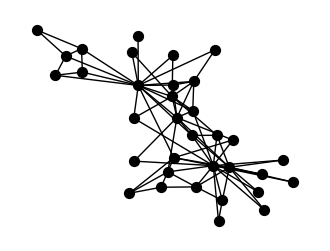

In [4]:
# Karate network
G = networkx.karate_club_graph()
pos = get_pos_spring(G)
graph_dump = (G, pos)
plot_network(G, pos)

# GroupID
group_id = np.zeros(G.number_of_nodes(), dtype=int)
for i in range(G.number_of_nodes()):
    if G.nodes[i]["club"] == "Mr. Hi":
        group_id[i] = 0
    elif G.nodes[i]["club"] == "Officer":
        group_id[i] = 1
    else:
        print("Warning: Unknown groupID.")
        group_id[i] = -1

# Adjacency matrix
P = int(max(map(max,G.edges))) + 1
W = np.zeros([P,P])
for x in G.edges:
    W[x[0],x[1]]=1.0
    W[x[1],x[0]]=1.0

---

#### LAPLACIAN & EIGENVECTORS

In [5]:
Dnorm = np.diag(np.sum(W, axis=1)**-1) # Normalized degree matrix

# Eigenvalue Laplacian
L = np.eye(P) - Dnorm @ W
e, v = scipy.linalg.eig(L)
e = np.real(e)
v = np.real(v)
order = np.argsort(e)
e = e[order]
v = v[:,order]

---

#### COMPUTE GRAPH

In [6]:
N = 2048
prob = 0.1
eta = 0.01
epochs = 3000
gamma = 0.3
a_arr = np.arange(-1.5, 3.1, 0.1)

a_hist, m_hist, cor_hist = [], [], []

In [7]:
graph = LAM(N, P, prob, W, gamma, 'asym')

In [8]:
for a_ind in tqdm(range(len(a_arr))):
    a = np.around(a_arr[a_ind], decimals=1)
    m_log, cor_activity = graph.simulate_allstarts(a, eta, epochs)
    m = m_log[-1,:,:]

    a_hist.append(a)
    m_hist.append(m)
    cor_hist.append(cor_activity)

100%|██████████| 46/46 [11:42<00:00, 15.27s/it]


---

#### PLOT RESULTS

In [9]:
def plot_color_network(G, pos, color_list):
    plt.figure(figsize=(4,3))
    color_list = color_list[G.nodes()]
    color_max = np.max([np.max(color_list), np.abs(np.min(color_list))])
    nc = networkx.draw_networkx_nodes(G, pos, node_color=list(color_list), cmap="Spectral", vmin=-color_max, vmax=color_max, node_size=50)
    networkx.draw_networkx_edges(G, pos)
    plt.axis("off")
    plt.colorbar(nc)

In [10]:
def plot_pattern_cor(cor):
    plt.figure(figsize=(4,3))
    plt.imshow(cor, cmap="Spectral", vmax=1, vmin=-1, extent=[0.5, P+0.5, P+0.5, 0.5])
    plt.xticks([1,P]), plt.yticks([1,P])
    plt.xlabel("Trigger stimulus"), plt.ylabel("Trigger stimulus")
    plt.colorbar()

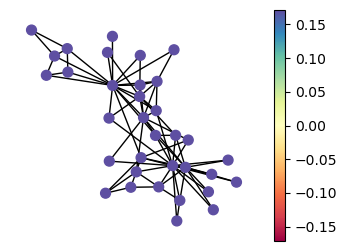

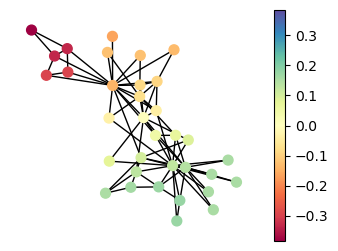

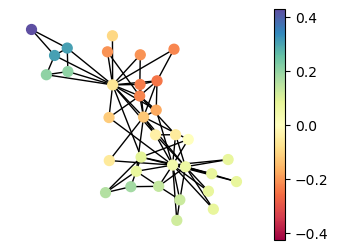

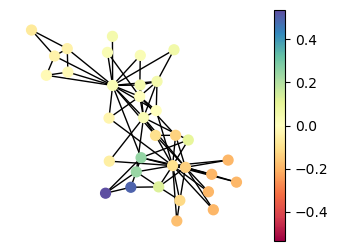

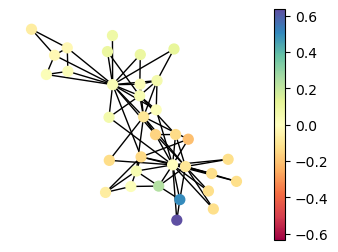

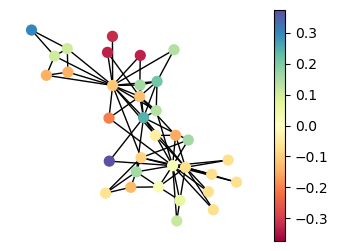

In [11]:
start_node = int(31)
sort_ind = np.argsort(group_id)

for i in range(6):
    plot_color_network(G, pos, v[:,i]),

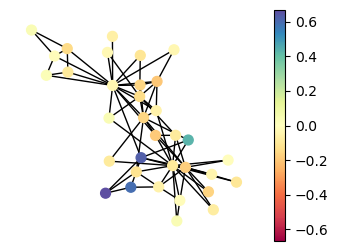

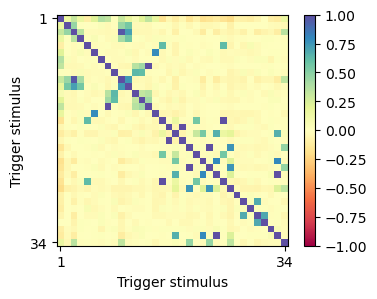

In [12]:
a_ind = 32 # 0-45 (Alpha index)
a = np.around(a_arr[a_ind],decimals=1)
m = m_hist[a_ind]
plot_color_network(G, pos, m[:,start_node])

cor_activity = cor_hist[a_ind]
cor_activity = cor_activity[:,sort_ind]
cor_activity = cor_activity[sort_ind,:]
plot_pattern_cor(cor_activity)

---

#### PLOT STATISTICS

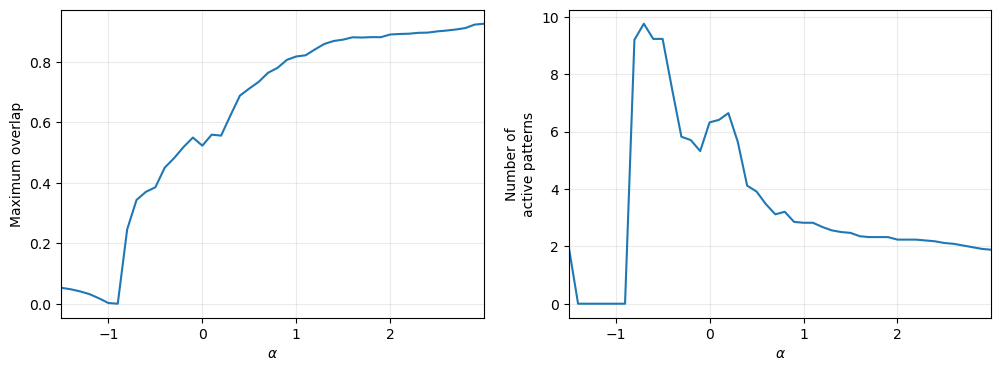

In [13]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    
    # Image Segmentation
    # max_m = np.max(m)
    # max_overlap[a_ind] = max_m
    
    max_m = np.max(m,axis=0, keepdims=True)
    max_overlap[a_ind]=np.mean(max_m)

    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.05), axis=0))

xlim=[np.min(a_arr), np.max(a_arr)]
xticks=[-1, 0, 1, 2]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

plt.subplot(1,2,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of\nactive patterns")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

---

#### EXPLAINED VARIANCE

/Users/James/opt/anaconda3/envs/dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/James/opt/anaconda3/envs/dev/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


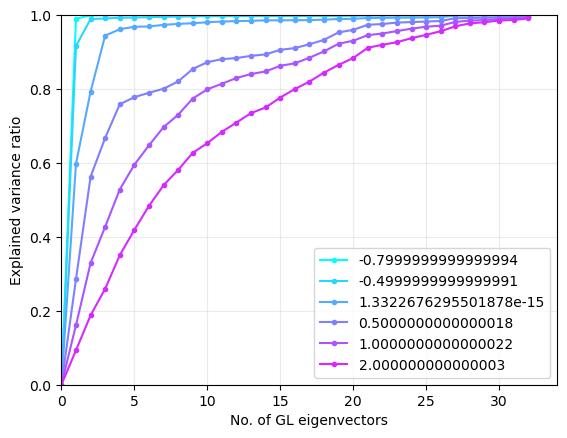

In [14]:
a_ind_pick=[7, 10, 15, 20, 25, 35]
a_arr=[a_arr[i] for i in a_ind_pick]
m_hist=[m_hist[i] for i in a_ind_pick]

p = v.shape[1]
Rsquare = np.zeros([len(a_arr),p])

# # EXPLAINED VAR (GL AND ATTRACTOR)
for a_ind in range(len(a_arr)):
    var = np.var(m_hist[a_ind])
    for i in range(p):
        coeff, res, rank, sing = np.linalg.lstsq(v[:,:i+1], m_hist[a_ind], rcond=None)
        Rsquare[a_ind,i] = 1-np.mean(res) / v.shape[0]/var

# SIMILARITY (OVERLAP AND BASES)
cm = plt.get_cmap("cool")
for i in range(len(a_arr)):
    plt.plot(Rsquare[i,:], ".-", label=str(a_arr[i]), color=cm(i/len(a_arr)))

plt.xlim([0,p]), plt.ylim([0,1])
plt.xlabel("No. of GL eigenvectors")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.grid('on', alpha=0.25)